# Car speed over time

In this part of the project the development of the speed of the cars will be investigated to answer the question: How much quicker did the cars get over time?

For this the following points will be investigated using the data that was prepared in the previous part:
- How much quicker did the fastest cars get?
- How much quicker did the slowest cars get?
- How much quicker did the cars on average get?

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("F1") \
    .getOrCreate()

25/05/01 15:32:59 WARN Utils: Your hostname, bdlc-004 resolves to a loopback address: 127.0.1.1; using 10.176.129.6 instead (on interface ens192)
25/05/01 15:32:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/01 15:32:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/01 15:33:00 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/05/01 15:33:00 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [2]:
!hdfs dfs -ls /f1/data/cleaned_*.parquet

Found 2 items
-rw-r--r--   2 cluster supergroup          0 2025-04-27 17:08 /f1/data/cleaned_circuits.parquet/_SUCCESS
-rw-r--r--   2 cluster supergroup       6904 2025-04-27 17:08 /f1/data/cleaned_circuits.parquet/part-00000-99e32ab9-9e0f-42b2-a6d3-42d4ef687d18-c000.snappy.parquet
Found 2 items
-rw-r--r--   2 cluster supergroup          0 2025-04-27 17:30 /f1/data/cleaned_constructor_results.parquet/_SUCCESS
-rw-r--r--   2 cluster supergroup      80657 2025-04-27 17:30 /f1/data/cleaned_constructor_results.parquet/part-00000-23998559-62d1-4e57-baa4-d4d192fefdfc-c000.snappy.parquet
Found 2 items
-rw-r--r--   2 cluster supergroup          0 2025-04-27 17:33 /f1/data/cleaned_constructor_standings.parquet/_SUCCESS
-rw-r--r--   2 cluster supergroup     110395 2025-04-27 17:33 /f1/data/cleaned_constructor_standings.parquet/part-00000-a866fd49-8cdf-4567-95b0-47dec9a9f110-c000.snappy.parquet
Found 2 items
-rw-r--r--   2 cluster supergroup          0 2025-04-27 17:34 /f1/data/cleaned_constructo

As a first step all the necessary datasets will be loaded and how they look like.

In [61]:
circuits_df = spark.read.parquet(f"/f1/data/cleaned_circuits.parquet")
lap_times_df = spark.read.parquet(f"/f1/data/cleaned_lap_times.parquet")
races_df = spark.read.parquet(f"/f1/data/cleaned_races.parquet")
# maybe use drivers
results_df = spark.read.parquet(f"/f1/data/cleaned_results.parquet")
# seasons_df = spark.read.parquet(f"/f1/data/cleaned_seasons.parquet")

In [4]:
circuits_df.show(1)
lap_times_df.show(1)
races_df.show(1)
results_df.show(1)
# seasons_df.show(1)

+---------+-----------+--------------------+---------+---------+--------+-------+
|circuitId| circuitRef|                name| location|  country|     lat|    lng|
+---------+-----------+--------------------+---------+---------+--------+-------+
|        1|albert_park|Albert Park Grand...|Melbourne|Australia|-37.8497|144.968|
+---------+-----------+--------------------+---------+---------+--------+-------+
only showing top 1 row

+------+--------+---+--------+--------+------------+
|raceId|driverId|lap|position|    time|milliseconds|
+------+--------+---+--------+--------+------------+
|   990|     840| 27|      16|1:38.414|       98414|
+------+--------+---+--------+--------+------------+
only showing top 1 row

+------+----+-----+---------+--------------------+----------+--------+--------+--------+--------+--------+--------+--------+----------+----------+-----------+-----------+
|raceId|year|round|circuitId|                name|      date|    time|fp1_date|fp1_time|fp2_date|fp2_time|

In [24]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import matplotlib.pyplot as plt

fastest_laps = lap_times_df.groupBy("raceId").agg(F.min("milliseconds").alias("fastest_lap"))
races_with_year = races_df.select("raceId", "year", "circuitId")
fastest_laps_with_year = fastest_laps.join(races_with_year, "raceId")
fastest_laps_with_year.show(5)

speed_development = fastest_laps_with_year.groupBy("circuitId", "year").agg(F.min("fastest_lap").alias("min_fastest_lap"))
circuits_with_name = circuits_df.select("circuitId", "name")
speed_development = speed_development.join(circuits_df, "circuitId")
speed_development.show(5)


+------+-----------+----+---------+
|raceId|fastest_lap|year|circuitId|
+------+-----------+----+---------+
|  1088|      73652|2022|       39|
|  1025|      95761|2019|       71|
|  1084|      67275|2022|       70|
|  1127|      78589|2024|       21|
|  1139|      97330|2024|       69|
+------+-----------+----+---------+
only showing top 5 rows

+---------+----+---------------+--------------+--------------------+----------+---------+--------+--------+
|circuitId|year|min_fastest_lap|    circuitRef|                name|  location|  country|     lat|     lng|
+---------+----+---------------+--------------+--------------------+----------+---------+--------+--------+
|       17|2010|         102061|      shanghai|Shanghai Internat...|  Shanghai|    China| 31.3389|  121.22|
|       11|2023|          80504|   hungaroring|         Hungaroring|  Budapest|  Hungary| 47.5789| 19.2486|
|       10|2000|         104300|hockenheimring|      Hockenheimring|Hockenheim|  Germany| 49.3278| 8.56583|
|  

# Fastest Lap Times Of All Circuits Continously Driven Over The Last 10 Years

Let's see how much F1 Cars evolved over the last 10 years be comparing the fastest lap times on the circuits which were constantly driven on.

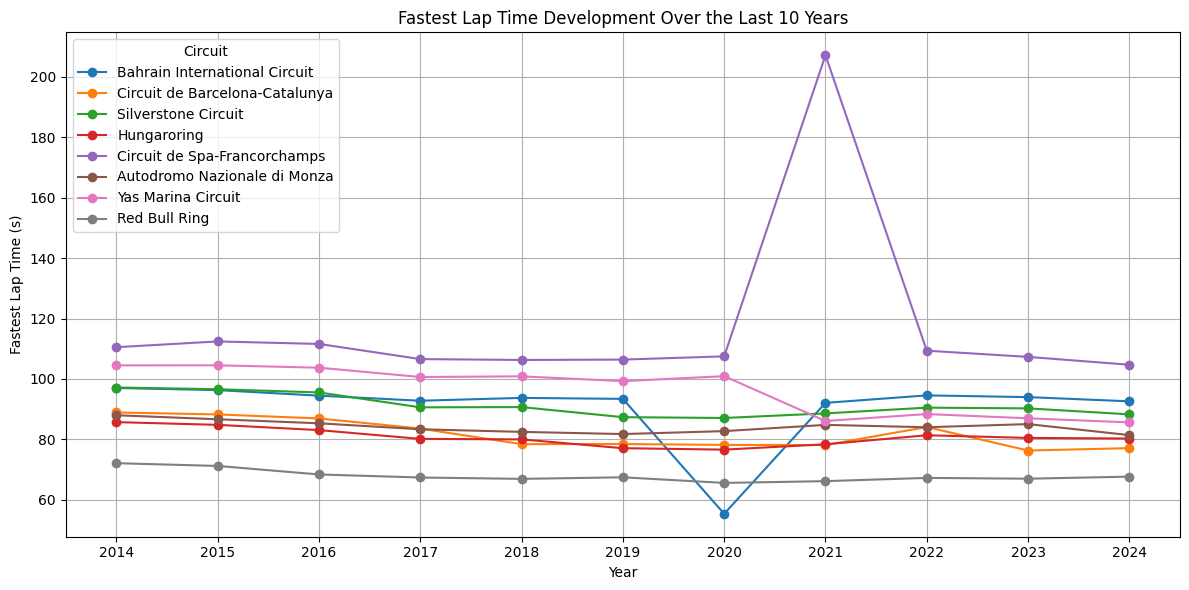

In [ ]:
current_year = 2024
include_last_x_years = 10
last_x_years = speed_development.filter(F.col("year") >= current_year - include_last_x_years)

speed_development_pd = last_x_years.toPandas()

num_years_required = include_last_x_years + 1
grouped = speed_development_pd.groupby('circuitId').filter(
    lambda x: x['year'].nunique() == num_years_required
).groupby('circuitId')

fig, ax = plt.subplots(figsize=(12, 6))

for circuit_id, group in grouped:
    group = group.sort_values(by='year')
    ax.plot(group['year'], group['min_fastest_lap'] / 1000, marker='o', label=group['name'].iloc[0])

ax.set_title('Fastest Lap Time Development Over the Last 10 Years')
ax.set_xlabel('Year')
ax.set_ylabel('Fastest Lap Time (s)')
# Ensure all years in the range are shown as ticks
ax.set_xticks(list(range(current_year - include_last_x_years, current_year + 1)))
ax.grid(True)
ax.legend(title='Circuit', loc='upper left') # Adjust legend position

plt.tight_layout()
plt.show()

## Observations

While most Laptimes are slightly decreasing over the years as expected, there are a few datapoints sticking out:
1. **Spa 2021**: The big spike in the fastest laptime is due to heavy rain which lead to the race never running under full green flag conditions. So the "fastet lap" was driven behind the Safety Car.
1. **Baharin 2020**: The fastest lap time was much quicker because it was held on the shorter and faster Bahrain Outer Circuit instead of the traditional layout due to COVID-19.
1. **Yas Marina 2021**: The track was redesigned, leading to a faster lap time due to a reduced number of slow-speed corners.

# Investigate specifics circuit over the years

Some circuits didn't change a lot over time, lets use them to compare the lap times

/tmp/ipykernel_1110804/2633873483.py:21: RankWarning: Polyfit may be poorly conditioned
  slope, intercept = np.polyfit(x, y, 1)
/tmp/ipykernel_1110804/2633873483.py:21: RankWarning: Polyfit may be poorly conditioned
  slope, intercept = np.polyfit(x, y, 1)
/tmp/ipykernel_1110804/2633873483.py:21: RankWarning: Polyfit may be poorly conditioned
  slope, intercept = np.polyfit(x, y, 1)


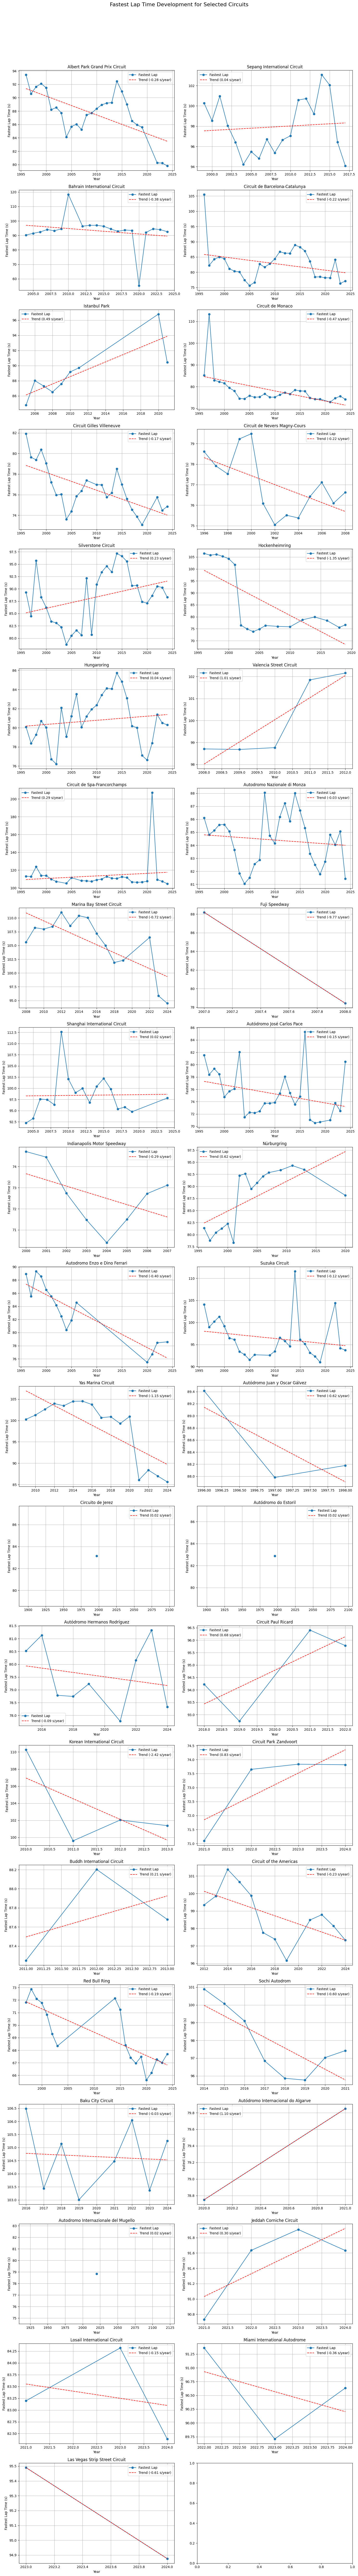

In [ ]:
import numpy as np

circuits = ['monza', 'monaco', 'interlagos', 'spa', 'silverstone', 'suzuka']
selected_circuits_df = speed_development.filter(F.col("circuitRef").isin(circuits)).toPandas().groupby("circuitId")

num_circuits = selected_circuits_df.ngroups
ncols = 2
nrows = (num_circuits + ncols - 1) // ncols
fig_multi, axes_multi = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
axes_multi = axes_multi.flatten()

for i, (circuit_id, group) in enumerate(selected_circuits_df):
    ax = axes_multi[i]
    group = group.sort_values(by='year')
    circuit_name = group['name'].iloc[0]
    ax.plot(group['year'], group['min_fastest_lap'] / 1000, marker='o', label='Fastest Lap')

    # Linear Regression
    x = group['year']
    y = group['min_fastest_lap'] / 1000
    slope, intercept = np.polyfit(x, y, 1)
    line_x = np.array([x.min(), x.max()])
    line_y = slope * line_x + intercept
    ax.plot(line_x, line_y, color='red', linestyle='--', label=f'Trend ({slope:.2f} s/year)')

    ax.set_title(circuit_name)
    ax.set_xlabel('Year')
    ax.set_ylabel('Fastest Lap Time (s)')
    ax.grid(True)
    ax.legend(loc='best')


plt.suptitle('Fastest Lap Time Development for Selected Circuits', fontsize=16, y=1.02) # Add overall title
plt.tight_layout()
plt.show()
